In [1]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import keras.backend as K
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.initializers import *
from keras.callbacks import *
from keras.utils.generic_utils import Progbar

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

K.tensorflow_backend._get_available_gpus()


Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11281385072024594333
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6575380890
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8110344375912608512
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:b3:00.0, compute capability: 7.5"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

(20000, 4000)


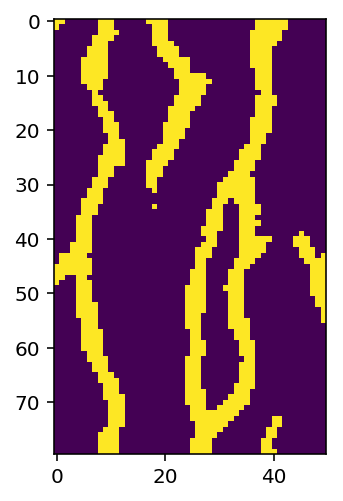

In [2]:
#tr_im = pd.read_csv("resample.csv",index_col=0).values
tr_im = np.loadtxt("reals.dat")
print(tr_im.shape)
nrow,ncol = 80,50
plt.imshow(tr_im[0,:].reshape(nrow,ncol))
tr_im = tr_im.reshape(tr_im.shape[0], 80, 50)


In [7]:
# random seed
RND = 777

# output settings
RUN = 'C'
OUT_DIR = 'out/' + RUN
TENSORBOARD_DIR = '/tensorboard/wgans/' + RUN
SAVE_SAMPLE_IMAGES = False

# GPU # to run on

BATCH_SIZE = 100
ITERATIONS = 200

# size of the random vector used to initialize G
Z_SIZE = 100

In [8]:
np.random.seed(RND)

In [9]:
# create output dir
if not os.path.isdir(OUT_DIR): os.makedirs(OUT_DIR)


# seed random generator for repeatability
np.random.seed(RND)

# force Keras to use last dimension for image channels
K.set_image_dim_ordering('tf')

In [10]:
def d_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [11]:
def create_D():

    # weights are initlaized from normal distribution with below params
    weight_init = RandomNormal(mean=0., stddev=0.02)

    input_image = Input(shape=(80, 50, 1), name='input_image')

    x = Conv2D(
        64, (3, 3),
        padding='same',
        name='conv_1',
        kernel_initializer=weight_init)(input_image)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size=1)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(
        128, (3, 3),
        padding='same',
        name='conv_2',
        kernel_initializer=weight_init)(x)
    x = MaxPool2D(pool_size=2)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(
        256, (3, 3),
        padding='same',
        name='conv_3',
        kernel_initializer=weight_init)(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(
        512, (3, 3),
        padding='same',
        name='coonv_4',
        kernel_initializer=weight_init)(x)
    x = MaxPool2D(pool_size=2)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    features = Flatten()(x)

    output_is_fake = Dense(
        1, activation='linear', name='output_is_fake')(features)


    return Model(
        inputs=[input_image], output=[output_is_fake], name='D')


In [12]:
def create_G(Z_SIZE=Z_SIZE):
    DICT_LEN = 10
    EMBEDDING_LEN = Z_SIZE

    # weights are initialized from normal distribution with below params
    weight_init = RandomNormal(mean=0., stddev=0.02)

    # class#
    input_class = Input(shape=(1, ), dtype='int32', name='input_class')
    # encode class# to the same size as Z to use hadamard multiplication later on
    e = Embedding(
        DICT_LEN, EMBEDDING_LEN,
        embeddings_initializer='glorot_uniform')(input_class)
    embedded_class = Flatten(name='embedded_class')(e)

    # latent var
    input_z = Input(shape=(Z_SIZE, ), name='input_z')

    # cnn part
    x = Dense(1024)(input_z)
    x = LeakyReLU()(x)

    x = Dense(200 * 8 * 5)(x)
    x = LeakyReLU()(x)
    x = Reshape((200, 8, 5))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (5, 5), padding='same', kernel_initializer=weight_init)(x)
    x = LeakyReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (5, 5), padding='same', kernel_initializer=weight_init)(x)
    x = LeakyReLU()(x)

    x = Conv2D(
        1, (2, 2),
        padding='same',
        activation='tanh',
        name='output_generated_image',
        kernel_initializer=weight_init)(x)

    return Model(input=[input_z], outputs=x, name='G')

In [13]:
D = create_D()

D.compile(
    optimizer=RMSprop(lr=0.00005),
    loss=[d_loss])

input_z = Input(shape=(Z_SIZE, ), name='input_z_')

G = create_G()

# create combined D(G) model
output_is_fake = D(G(inputs=[input_z]))
DG = Model(inputs=[input_z], outputs=[output_is_fake])

DG.compile(
    optimizer=RMSprop(lr=0.00005),
    loss=[d_loss]
)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., name="D", outputs=[<tf.Tenso...)`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ou..., name="G", inputs=[<tf.Tenso...)`


In [14]:
# load mnist data

# use all available 70k samples from both train and test sets
X_train = tr_im
X_train = np.expand_dims(X_train, axis=3)




In [15]:
# save 10x10 sample of generated images
def generate_samples(n=0, save=True):

    zz = np.random.normal(0., 1., (100, Z_SIZE))
    generated_classes = np.array(list(range(0, 10)) * 10)
    generated_images = G.predict([zz, generated_classes.reshape(-1, 1)])

    rr = []
    for c in range(10):
        rr.append(
            np.concatenate(generated_images[c * 10:(1 + c) * 10]).reshape(
                280, 28))
    img = np.hstack(rr)

    if save:
        plt.imsave(OUT_DIR + '/samples_%07d.png' % n, img, cmap=plt.cm.gray)

    return img

# write tensorboard summaries
sw = tf.summary.FileWriter(TENSORBOARD_DIR)
def update_tb_summary(step, write_sample_images=True):

    s = tf.Summary()

    # losses as is
    for names, vals in zip((('D_real_is_fake', 'D_real_class'),
                            ('D_fake_is_fake', 'D_fake_class'), ('DG_is_fake',
                                                                 'DG_class')),
                           (D_true_losses, D_fake_losses, DG_losses)):

        v = s.value.add()
        v.simple_value = vals[-1][1]
        v.tag = names[0]

        v = s.value.add()
        v.simple_value = vals[-1][2]
        v.tag = names[1]

    # D loss: -1*D_true_is_fake - D_fake_is_fake
    v = s.value.add()
    v.simple_value = -D_true_losses[-1][1] - D_fake_losses[-1][1]
    v.tag = 'D loss (-1*D_real_is_fake - D_fake_is_fake)'

    # generated image
    if write_sample_images:
        img = generate_samples(step, save=True)
        s.MergeFromString(tf.Session().run(
            tf.summary.image('samples_%07d' % step,
                             img.reshape([1, *img.shape, 1]))))

    sw.add_summary(s, step)
    sw.flush()

In [16]:
progress_bar = Progbar(target=ITERATIONS)

DG_losses = []
D_true_losses = []
D_fake_losses = []

for it in range(ITERATIONS):

    if len(D_true_losses) > 0:
        progress_bar.update(
            it,
            values=[ # avg of 5 most recent
                    ('D_real_is_fake', np.mean(D_true_losses[-5:], axis=0)[1]),
                    ('D_real_class', np.mean(D_true_losses[-5:], axis=0)[2]),
                    ('D_fake_is_fake', np.mean(D_fake_losses[-5:], axis=0)[1]),
                    ('D_fake_class', np.mean(D_fake_losses[-5:], axis=0)[2]),
                    ('D(G)_is_fake', np.mean(DG_losses[-5:],axis=0)[1]),
                    ('D(G)_class', np.mean(DG_losses[-5:],axis=0)[2])
            ]
        )
        
    else:
        progress_bar.update(it)

    # 1: train D on real+generated images

    if (it % 1000) < 25 or it % 500 == 0: # 25 times in 1000, every 500th
        d_iters = 100
    else:
        d_iters = d_iters

    for d_it in range(d_iters):

        # unfreeze D
        D.trainable = True
        for l in D.layers: l.trainable = True

        # clip D weights

        for l in D.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -0.01, 0.01) for w in weights]
            l.set_weights(weights)

        # 1.1: maximize D output on reals === minimize -1*(D(real))

        # draw random samples from real images
        index = np.random.choice(len(X_train), BATCH_SIZE, replace=False)
        real_images = X_train[index]
       

        D_loss = D.train_on_batch(real_images, [-np.ones(BATCH_SIZE)])
        D_true_losses.append(D_loss)

        # 1.2: minimize D output on fakes 

        zz = np.random.normal(0., 1., (BATCH_SIZE, Z_SIZE))
        generated_classes = np.random.randint(0, 10, BATCH_SIZE)
        generated_images = G.predict([zz, generated_classes.reshape(-1, 1)])

        D_loss = D.train_on_batch(generated_images, [np.ones(BATCH_SIZE),
          generated_classes])
        D_fake_losses.append(D_loss)

    # 2: train D(G) (D is frozen)
    # minimize D output while supplying it with fakes, 
    # telling it that they are reals (-1)

    # freeze D
    D.trainable = False
    for l in D.layers: l.trainable = False

    zz = np.random.normal(0., 1., (BATCH_SIZE, Z_SIZE)) 
    generated_classes = np.random.randint(0, 10, BATCH_SIZE)

    DG_loss = DG.train_on_batch(
        [zz, generated_classes.reshape((-1, 1))],
        [-np.ones(BATCH_SIZE), generated_classes])

    DG_losses.append(DG_loss)

    if it % 10 == 0:
        update_tb_summary(it, write_sample_images=(it % 250 == 0))

  0/200 [..............................] - ETA: 0s

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2 arrays: [array([[ 1.60373878,  0.69203603,  0.40767445, ...,  1.41442788,
        -1.0298615 , -0.33651456],
       [-0.15967272, -0.6099801 ,  1.13309405, ..., -0.13717187,
        -0.70636174, -1.12904649],...